# Домашняя работа

1. Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)
2. Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей
3. Построить случайный лес, вывести важность признаков
4. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
5. Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
6. Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)
7. В качестве решения:
    Jupyter notebook с кодом, комментариями и графиками

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

In [2]:
data = pd.read_csv('train_4hw.csv')
data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Перед выполнением основной работы займемся предподготовкой данных.

In [3]:
#Находим категориальные признаки
cat_feat = list(data.dtypes[data.dtypes == object].index)

#закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
data[cat_feat] = data[cat_feat].fillna('nan')

#отфильтруем непрерывные признаки
num_feat = [f for f in data if f not in (cat_feat + ['ID', 'target'])]

# Смотрим сколько у нас значений по каждому категориальному признаку
cat_nunique = data[cat_feat].nunique()

#Чтобы в разы не увеличивать число признаков при построении dummy,
#будем использовать категориальные признаки с < 30 уникальных значений
cat_feat = list(cat_nunique[cat_nunique < 30].index)

# Создаем дамми-переменные для категорий
dummy_data = pd.get_dummies(data[cat_feat], columns=cat_feat)



# Заменяем пропуски на специальное значение -999, чтобы деревья могли их отличить
#  и отнормируем на всякий случай непрерывные признаки
scaler=StandardScaler()
X = pd.concat([pd.DataFrame(scaler.fit_transform(data[num_feat]), columns=data[num_feat].columns),
                dummy_data], axis=1)
X=X.fillna(X.mean())
X.drop(['SalePrice'], axis=1, inplace=True)

y = pd.DataFrame(data={'SalePrice': data.SalePrice})
y=y.fillna(y.mean())

C:\Users\Volk\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Volk\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


#### Задания 1-3
Итак, для решения этой задачи разобьем исходную выборку на 10 наборов (fold's). Для каждой части построим свой случайный лес и определим выжность признаков (в долях). Затем, для всех таких экспериментов расчитаем общую среднюю величину важности признаков - это и будет ответом.

In [4]:
n_kfold=10

kf = KFold(n_splits=n_kfold, random_state=5, shuffle=True)
model = RandomForestRegressor(n_estimators=100)

imp0=[]
first_iter_flag = 0
for train_index, test_index in kf.split(X):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    model.fit(X_train, y_train.ravel())
    imp = model.feature_importances_
    if first_iter_flag == 0:
        imp0=imp
        #np.array(imp).reshape((-1, 1))
        first_iter_flag=1
    else:
        imp0=imp0+imp
        #np.array(imp).reshape((-1, 1))
        
imp0=imp0/n_kfold
ix=np.argsort(-imp0)

Самый важный признак (первые пять).

In [5]:
for i in range(1,6):
    print(X.columns[ix[i]],': ',str(imp0[ix[i]].round(3)))

GrLivArea :  0.111
TotalBsmtSF :  0.038
2ndFlrSF :  0.031
BsmtFinSF1 :  0.028
1stFlrSF :  0.024


#### Задания 4-6

In [6]:
from sklearn.linear_model import HuberRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

Определим оптимальное количество n_neighbors для KNeighborsRegressor.

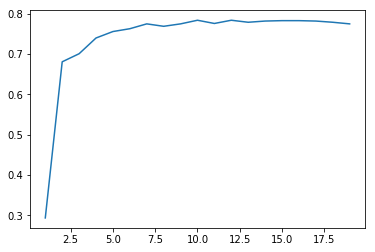

In [7]:
ks=range(1,20)
r2_val=[]
for n in ks:
    model = KNeighborsRegressor(n_neighbors=n)
    model.fit(X_train,y_train.ravel())
    y_pred=model.predict(X_test)
    r2_val.append(r2_score(y_test, y_pred).round(3))
plt.plot(ks, r2_val)
plt.show()

Определим взаимные веса w1, w2, w3 для стекинга где метоалгоритм - линейная модель (в качестве метрики возьмем корреляцию).

In [8]:
algorithms = [
    RandomForestRegressor(n_estimators=10, max_depth = 5, min_samples_leaf = 20, max_features = 0.5, n_jobs = 1),
    HuberRegressor(),
    KNeighborsRegressor(n_neighbors=4),
]

In [9]:
n_kfold=10
kf = KFold(n_splits=n_kfold, random_state=5, shuffle=True)
r2_val2=np.array([0,0,0])
for train_index, test_index in kf.split(X):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    r2_val=[]
    for i in range(0,3):
        model=algorithms[i]
        #if i==1:
        #    model=RandomForestRegressor(n_estimators=10, max_depth = 5, min_samples_leaf = 20, max_features = 0.5, n_jobs = 1)
        #if i==2:
        #    model=HuberRegressor()
        #else:
        #    model = KNeighborsRegressor(n_neighbors=4)
        model.fit(X_train, y_train.ravel())
        y_pred=model.predict(X_test)
        r2_val.append(r2_score(y_test, y_pred).round(3))
    r2_val2=r2_val2+np.array(r2_val)
r2_val2 = r2_val2/n_kfold
print('Средние (по kfold=10) значения корреляций:')
print('RanFor Huber KNN')
print(str(r2_val2))

Средние (по kfold=10) значения корреляций:
RanFor Huber KNN
[0.8022 0.8328 0.7507]


In [10]:
w=(r2_val2-0.5)
w=w/sum(w)
print('Итоговые веса для стекинга:')
print('RanFor Huber KNN')
print(str(w.round(4)))

Итоговые веса для стекинга:
RanFor Huber KNN
[0.3412 0.3757 0.2831]


In [11]:
def get_meta_features(clf, X_train, y_train, X_test, stack_cv, variant):
    meta_train = np.zeros_like(y_train, dtype=float)
    meta_test = np.zeros_like(y_test, dtype=float)

    for i, (train_ind, test_ind) in enumerate(stack_cv.split(X_train, y_train)):

        clf.fit(X_train.iloc[train_ind], y_train.iloc[train_ind].values)
        if variant == 1:
            meta_train[test_ind] = clf.predict(X_train.iloc[test_ind])[0]
            meta_test += clf.predict(X_test)[0]
        else:
            meta_train[test_ind] = clf.predict(X_train.iloc[test_ind]).reshape(-1,1)
            meta_test += clf.predict(X_test).reshape(-1,1)
            
    return meta_train, meta_test / stack_cv.n_splits

In [12]:
# Поделим на train (для базовых алгоритмов) и test (для метоалгоритма)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) 

In [14]:
from sklearn.model_selection import StratifiedKFold

stack_cv = StratifiedKFold(n_splits=10, random_state=12345)

meta_train = []
meta_test = []
col_names = []
k=0;
for i in range(0,3):
        if i==0:
            col_names.append('RanFor_pred')
            variant=1
        if i==1:
            col_names.append('Huber_pred')
            variant=2
        if i==2:
            col_names.append('KNN_pred')
            variant=2
        model=algorithms[i]
        meta_tr, meta_te = get_meta_features(model, X_train, y_train, X_test, stack_cv, variant)
        meta_train.append(meta_tr)
        meta_test.append(meta_te)
        k=k+1
X_meta_train = pd.DataFrame(np.stack(meta_train, axis=1)[:,:,0], columns=col_names)
X_meta_test = pd.DataFrame(np.stack(meta_test, axis=1)[:,:,0], columns=col_names)

C:\Users\Volk\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Volk\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
C:\Users\Volk\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
C:\Users\Volk\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
C:\Users\Volk\Ana

В качестве мета-алгоритма рассмотрим весовую функцию, роббастную линейную регрессию, лес решений и регрессию "ближайшего соседа".
Так как это задача регрессии для оценки качества используем метрику квадрата корреляции, а в качестве визуализации - кроссплот предсказаний с целевой переменной (на отложенной выборке).

C:\Users\Volk\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Volk\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


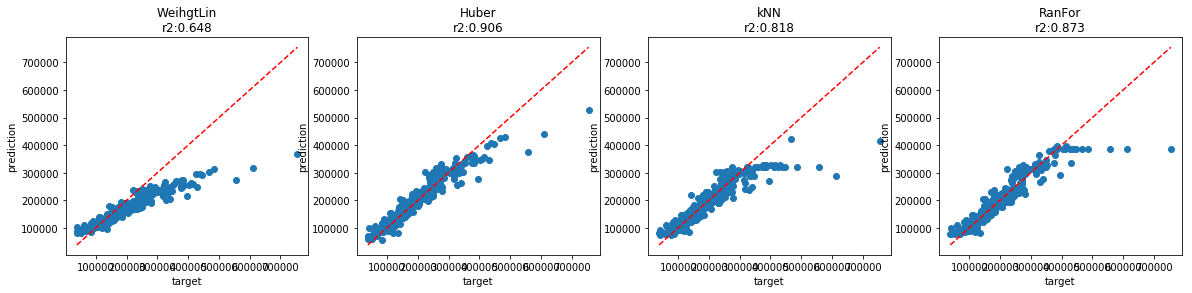

In [15]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
#axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters_random, cmap='autumn', s=60, alpha=alpha)
#axes[0].set_title(get_descr("Random", y, clusters_random, X_scaled))
k=0;
for ax in axes:
    if k==0:
        y_pred_meta_test=w[0]*X_meta_test.values[:,0]+w[1]*X_meta_test.values[:,1]+w[2]*X_meta_test.values[:,2]
        algorithm_name='WeihgtLin'
    if k==1:
        model = HuberRegressor()
        model.fit(X_meta_train, y_train)
        y_pred_meta_test = model.predict(X_meta_test)
        algorithm_name='Huber'
    if k==2:
        model = KNeighborsRegressor(n_neighbors=4)
        model.fit(X_meta_train, y_train)
        y_pred_meta_test = model.predict(X_meta_test)
        algorithm_name='kNN'
    if k==3:
        model = RandomForestRegressor(n_estimators=10, max_depth = 5, min_samples_leaf = 10, max_features = 0.75, n_jobs = 1)
        model.fit(X_meta_train, y_train)
        y_pred_meta_test = model.predict(X_meta_test)
        algorithm_name='RanFor'
    mi=min([y_test.values.min(),y_pred_meta_test.min()])
    ma=max([y_test.values.max(),y_pred_meta_test.max()])
    ax.scatter(y_test, y_pred_meta_test)
    ax.plot([mi,ma], [mi,ma] ,'r--')
    ax.set_title(algorithm_name+'\nr2:'+ str(r2_score(y_test, y_pred_meta_test).round(3)))
    ax.set(xlabel='target', ylabel='prediction')
    k=k+1

Лучший результат показала мета-линейная модель с роббастной регрессией (Huber). И ансамблирование уже подавно лучше чем отдельные модели (Рассмотренные выше), что наглядно видно по коэфициэнтам квадрата корреляции.